# Prediction of Competition Weight at Specific Event Using Fitbod Exercise Data

The goal for powerlifting is to hit the highest weight an athlete can sustain for 3 separate lifts of the same exercise ([ALI](https://ali.usc.edu/blog/what-is-powerlifting/#:~:text=The%20goal%20of%20powerlifting%20is,final%20score%20a%20competitor%20receives.&text=The%20powerlifting%20squat%20begins%20when,%E2%80%9Cthe%20bar%20is%20loaded%E2%80%9D.)). It takes hard training and good programs to get the best results when preparing for a competition. It can be hard for atheletes without dedicated coaches to gain an understanding of how they are progressing when their training. 

One method many lifters use to gauge progress is to calulcate their 1 rep max for an excisse based on the repetitions and weights used on the last set of that exercise. It is fairly easy to calculate this value with past lifting records, but it can be quite difficult to project what this 1 Rep Max will be in the future.

Luckily with data science and machine learning methods, we can train a model to represent the progress that has been historically made and use this model to predict future progress.

This project will be built off a subset of data provided by Fitbod. 

In [2]:
# import statements
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss

### Reading the Data

The first step in a prediciton project is to load in the data and verify that it contains the data we were expecting.

For this process, we will be loading the data (.csv file) in using pandas so we can easily visualize and summarize the data.

In [3]:
# read data into pandas daraframe
workout_data = pd.read_csv("fitbod_Chelsi_Snellen_20220111-142302.csv")

In [4]:
workout_data.head()

,Date,workoutId,exerciseId,singleSetId,exerciseName,reps,weight,fake_user_id
0,2021-04-02,HUJu6AdGOk,zJlvUiMLou,Fm7jLH1lAB,Barbell Incline Bench Press,12,24.94761,fake_id_848
1,2021-08-25,Rn6VDxiH2b,9VAkz3bNl4,rTeFsHMSfe,Decline Push Up,9,0.00000,fake_id_879
2,2021-03-31,JkzNc0gF0q,9VAkz3bNl4,ratKHN7npU,Decline Push Up,6,0.00000,fake_id_877
3,2021-07-24,EvnhkkalIF,243X43p1XP,k8BENDtwWA,Seated Leg Curl,10,23.00000,fake_id_868
4,2021-05-27,szSeHOE6Gl,k3yxx2a6oz,Fb629JSV7u,Seated Machine Calf Press,10,99.79044,fake_id_850


With this preview, we can see that the data contains information about user's workouts, with specific exercises and weights, that are logged within Fitbod.

We can also see that there is a mix of categorical and numerical varaibles.

Our categorical variables are:
- Date
- workoutId
- exerciseId
- singleSetId
- exerciseName
- fake_user_id

The numerical variables are:
- reps 
- weight

This is important to note because it will influence how we approach cleaning the data.

## Data Cleaning

After we have read in the data and verified that it is in fact the data we were expecting, we need to look through the general statistics of the data and look for any warnings that we need to clean some information from the data. 

Some of the red flags we are looking for:
- Variables lacking meaningful information
- Variables that are highly correlated with each other
- Outliers within numerical data
- Missing values

In [5]:
workout_data.describe(include='all')

,Date,workoutId,exerciseId,singleSetId,exerciseName,reps,weight,fake_user_id
count,34639,34639,34639,34639,34639,34639.000000,34639.000000,34639
unique,366,5332,106,34639,106,NaN,NaN,77
top,2021-02-22,z51Loawu9T,G1mxtZtEs5,Fm7jLH1lAB,Back Squat,NaN,NaN,fake_id_858
freq,211,35,1436,1,1436,NaN,NaN,1706
mean,NaN,NaN,NaN,NaN,NaN,10.747539,19.142052,NaN
std,NaN,NaN,NaN,NaN,NaN,5.901469,30.383870,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,8.000000,0.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,10.000000,9.071858,NaN
75%,NaN,NaN,NaN,NaN,NaN,13.000000,29.483539,NaN


### Categorical Variable Cleaning
 
We can see that are a total of **34,639** rows in the dataset. 

Most of the cartegorical variable's unique number of values are significantly less than that total. This is important to note because if there is a smaller subset of values interspersed throughout the dataset, there is a high chance that important relationships form between these variables. This means that Date, workoutId, exerciseId, exerciseName, and fake_user_id are potential variables to in a prediction model.

The one categorical variable that stands out is the **singleSetId**. From the descriptive table above, we can see that the unique number of values for the variable is equal to the total number rows in the dataset. Thus means that there is a unique value in this for every single row. This leaves no potential for relationships with this variable. From this reasoning, we can conclude that this variable would not be useful in creating a prediction model and can be removed from the dataset for the purposes of this analysis.

In [6]:
useful_variables = workout_data.columns.to_list()
useful_variables.remove("singleSetId")
workout_data = workout_data[useful_variables]

Another interesting thing to note from the descriptive table is that from a cursory glance it looks like **exerciseId** and **exerciseName** have a 1 to 1 relationship (they contain the exact same information). These two variables have the same number of unique values as well as the same freq for their most seen value. 

The first test to see if they are in fact a 1 to 1 relationship is to see if we get a 1 to many relationship when we query a single exerciseID or exerciseName. 

For this test we will query the table with the exercise nane of 'Back Squat'.

In [7]:
query_results = workout_data[workout_data["exerciseName"] == "Back Squat"]["exerciseId"].unique()[0]
print("Results of query for exerciseId with the exercise Name of 'Back Squat':")
print(f'\t {query_results}')

Results of query for exerciseId with the exercise Name of 'Back Squat':
	 G1mxtZtEs5


We can verify with the query that in fact there is only one exerciseId present for the exerciseName 'Back Squat'.

Since the data is categorical, we can't easily extract an r value for the correlation between these two varaibles so instead we can run through the exercise names and verify that each one is only accompanied with a single exerciseId

In [8]:
correlated = True
non_correlated = []
for exercise in workout_data["exerciseName"].unique():
    query_results = workout_data[workout_data["exerciseName"] == "Back Squat"]["exerciseId"].unique()
    if len(query_results) > 1:
        correlated = False
        non_correlated.append(exercise)

if correlated:
    print("There is a 1 to 1 relationship between exerciseId and exerciseName")
else:
    print("There is a 1 to many relationship between exerciseName and exerciseId for these exercises: ")
    print(non_correlated)

There is a 1 to 1 relationship between exerciseId and exerciseName


From the print out, we can verify that for every exerciseName, there is only one exerciseId. 

Since they have a 1 to 1 relationship, we only need to keep one of these columns within the dataset. 

My personal preference is to keep exerciseName since it has more meaning semantically than the randomly generated exerciseId. 

In [9]:
useful_variables = workout_data.columns.to_list()
useful_variables.remove("exerciseId")
workout_data = workout_data[useful_variables]

For ease of use, the Date variable will also be converted to a datetime object for comparisons.

In [10]:
workout_data["Date"] = pd.to_datetime(workout_data["Date"])

### Numerical Data Cleaning

Now that we have the categorical variables cleaned and ready to analyze, we need to focus our attention on the numerical variables of 
reps and weight

In [11]:
workout_data.describe()

,reps,weight
count,34639.000000,34639.000000
mean,10.747539,19.142052
std,5.901469,30.383870
min,0.000000,0.000000
25%,8.000000,0.000000
50%,10.000000,9.071858
75%,13.000000,29.483539
max,300.000000,1821.175531


One major issue that is apparent when looking at this table is that the max value for reps and weight far exceed what a regular person should be able to do. This hints that there might be errors within this portion of the dataset.

Lets explore more.

#### Reps

For reps, we can see that the max number seen within the dataset is 300. 

In [12]:
descript_df = workout_data.describe()["reps"]
stds_max_mean = (descript_df.loc["max"] - descript_df.loc["mean"])/descript_df.loc["std"]
stds_max_75 = (descript_df.loc["max"] - descript_df.loc["75%"])/descript_df.loc["std"]
print(f"Reps Max is {stds_max_mean:.2f} standard deviations from the mean")
print(f"Reps Max is {stds_max_75:.2f} standard deviations from the 75% quartile")

Reps Max is 49.01 standard deviations from the mean
Reps Max is 48.63 standard deviations from the 75% quartile


As you can see this max value is drastcially larger than both the mean and the 75% percentile which is further evidence that this may be erroneous data. 

Lets take a look at a plot of the reps data to see if there is a cluster around the max value or if it is truly an outlier.

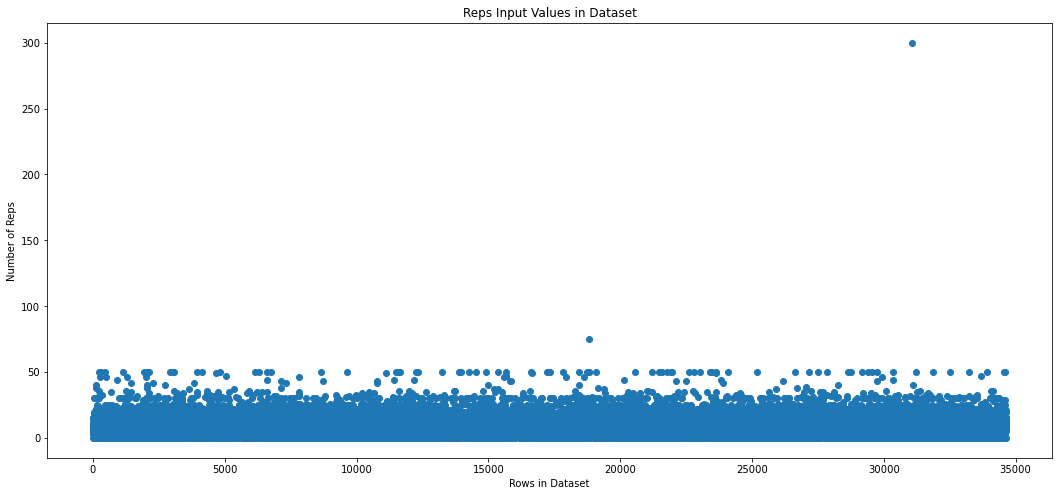

In [13]:
plt.figure(figsize=(18,8))
reps_values = workout_data["reps"].values
x = np.arange(0,len(reps_values))
plt.scatter(x,reps_values)
plt.title("Reps Input Values in Dataset")
plt.ylabel("Number of Reps")
plt.xlabel("Rows in Dataset")
plt.show()

This graph does in fact show that the 300 is an outlier but it also looks like we may have another outlier around 75. 

I am inclined to believe that this 75 is also an outlier because there seems to be a hard cutoff line for reps seen at 50. 

Lets get the exact value of the other outlier.

In [14]:
unique_reps = np.unique(reps_values)
unique_reps.sort()
print(f"Last 5 value in Reps data: {unique_reps[-5:]}")

Last 5 value in Reps data: [ 47  49  50  75 300]


Indeed, our two outliers are 75 and 300. Since these outliers represent approximately .005% of the data. It is probably best just to remove those records from the table.

In [15]:
workout_data = workout_data.drop(workout_data[workout_data['reps'].isin([75,300])].index)
workout_data.describe()

,reps,weight
count,34637.000000,34637.000000
mean,10.737333,19.142830
std,5.682820,30.384544
min,0.000000,0.000000
25%,8.000000,0.000000
50%,10.000000,9.071858
75%,13.000000,29.483539
max,50.000000,1821.175531


We can see that dropping the rows has brought the max down to 50 with a more reasonable spread for the percentiles and standard deviations

### Weight

The max weight seen in the dataset is 1821.

In [16]:
descript_df = workout_data.describe()["weight"]
stds_max_mean = (descript_df.loc["max"] - descript_df.loc["mean"])/descript_df.loc["std"]
stds_max_75 = (descript_df.loc["max"] - descript_df.loc["75%"])/descript_df.loc["std"]
print(f"Weight Max is {stds_max_mean:.2f} standard deviations from the mean")
print(f"Weight Max is {stds_max_75:.2f} standard deviations from the 75% quartile")

Weight Max is 59.31 standard deviations from the mean
Weight Max is 58.97 standard deviations from the 75% quartile


Again we can see that this max is drastically outside the distrubtion of values for the weight data. 

We'll again plot the data to detect any outliers or clusters in the extreme parts of the range.

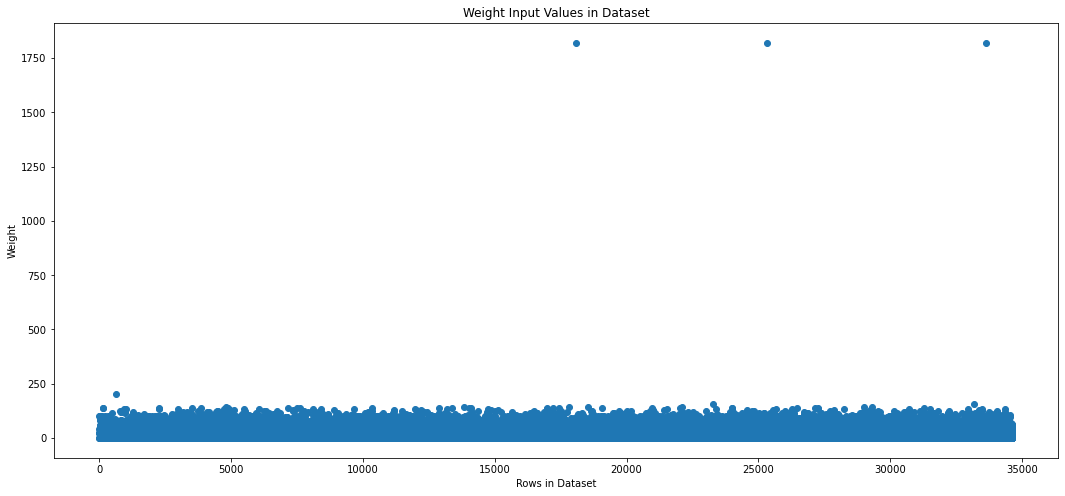

In [17]:
plt.figure(figsize=(18,8))
weight_values = workout_data["weight"].values
x = np.arange(0,len(weight_values))
plt.scatter(x,weight_values)
plt.title("Weight Input Values in Dataset")
plt.ylabel("Weight")
plt.xlabel("Rows in Dataset")
plt.show()

It seems that we do in fact have 3 other values around that max value.

Lets get the exact values.

In [18]:
weight_reps = np.unique(weight_values)
weight_reps.sort()
print(f"Last 5 value in Reps data: {weight_reps[-5:]}")

Last 5 value in Reps data: [ 142.88176647  145.14973102  156.48955376  204.11680925 1821.17553138]


It seems that the max value has three repetitions within the dataset. 

Since these three data points make up .009% of the data, it is probably best to do the same things as we did with the reps and remove these three values from the dataset.

In [19]:
workout_data = workout_data.drop(workout_data[workout_data['weight'] == descript_df.loc["max"]].index)
workout_data.describe()

,reps,weight
count,34634.000000,34634.000000
mean,10.737397,18.986737
std,5.683062,25.337417
min,0.000000,0.000000
25%,8.000000,0.000000
50%,10.000000,9.071858
75%,13.000000,29.483539
max,50.000000,204.116809


Dropping those three rows from the dataset seems to have corrected to erroneous max value we saw earlier.

### Check For and Remove/Impute Missing Values

The last part of the data cleaning process that we need to perform is to check the dataset for missing/NaN values and either remove them or impute some values.

First let's check if there any missing (NaN) values within the dataset.

In [20]:
any_nans = workout_data.isnull().values.any()

if any_nans:
    print("There are missing values within the dataset.")
else:
    print("The dataset is clear of any missing values")

The dataset is clear of any missing values


Looks like there are no missing values within the dataset so we don't need to remove or impute any values. 

 ## Exploratory Analysis

Now that the data is clean and free from erroneous values and contains only the variables we want to explore, we can start looking for trends within the data that can influence our prediction model. 

Some of the trends/questions we want to explore are:
- What overall data do we have in the dataset?
- Does the time of the year influence the number of workouts?
- How many days a year are users working out?
- What is the spread for the number of exercises within a singular workout?
- Does projected 1 Rep Max increase over the year?

### What is the Overall Statistics within the Dataset?
For this question, we generally want to see the types of data within the dataset such as:
- How many unique users?
- Who are the most active users?
- How many unique workouts?
- How many unique exercises?
- What are the exercises available?
- What are the most logged exercises?

In [21]:
print(f'Total Number of Users in Dataset: {len(workout_data["fake_user_id"].unique())}')

Total Number of Users in Dataset: 77


In [22]:
print(f'Most Active Users in Dataset: \r\n{workout_data["fake_user_id"].value_counts()}')

Most Active Users in Dataset: 
fake_id_858    1706
fake_id_848    1408
fake_id_838    1380
fake_id_835    1105
fake_id_847    1081
               ... 
fake_id_906      32
fake_id_910      28
fake_id_899      16
fake_id_905      15
fake_id_908       4
Name: fake_user_id, Length: 77, dtype: int64


In [23]:
print(f'Total Number of Workouts in Dataset: {len(workout_data["workoutId"].unique())}')

Total Number of Workouts in Dataset: 5331


In [24]:
print(f'Total Number of Exercises in Dataset: {len(workout_data["exerciseName"].unique())}')

Total Number of Exercises in Dataset: 106


In [25]:
print(f'Exercises in Dataset: {workout_data["exerciseName"].unique()}')

Exercises in Dataset: ['Barbell Incline Bench Press' 'Decline Push Up' 'Seated Leg Curl'
 'Seated Machine Calf Press' 'Bent Over Barbell Row' 'Air Squats'
 'Incline Dumbbell Row' 'Power Clean' 'Plank' 'Dumbbell Squeeze Press'
 'Machine Fly' 'TRX Atomic Push Up' 'Overhead Weighted Sit Up'
 'Barbell Hip Thrust' 'Cable Hip Abduction' 'Sit Up' 'Clean and Jerk'
 'Machine Leg Press' 'Glute Ham Raise Situp' 'Oblique Crunch'
 'Pendlay Row' 'Handle Band Pec Fly' 'Step Up' 'Reverse Barbell Curl'
 'Calf Raise' 'Romanian Deadlift' 'Side Laterals to Front Raise'
 'Hang Clean' 'Barbell Shoulder Press' 'Dumbbell Shrug' 'Tricep Push Up'
 'Dumbbell Rear Delt Raise' 'Dumbbell Kickbacks' 'Russian Twist'
 'Leg Raise' 'Kettlebell Upright Row' 'Dead Bug' 'Dumbbell Sumo Squat'
 'Scapular Pull Up' 'Dumbbell Clean' 'Smith Machine Calf Raise'
 'Reverse Grip Barbell Bent Over Row' 'Back Squat' 'Cable Crunch'
 'Dumbbell Shoulder Raise' 'Medicine Ball Push Up' 'Lunge Jump'
 'Australian Chin Up' 'Dumbbell Decline B

In [26]:
print(f'Most Logged Exercises in Dataset: {workout_data["exerciseName"].value_counts()}')

Most Logged Exercises in Dataset: Back Squat                 1436
Plank                      1346
Air Squats                 1300
Leg Raise                  1295
Dumbbell Kickbacks         1226
                           ... 
TRX Side Plank                6
Sled Pull                     3
Kettlebell Pistol Squat       3
TRX Pulse Lunges              3
Torture Twist                 3
Name: exerciseName, Length: 106, dtype: int64


### Does the Time of Year Influence the Number of Workouts by Users?

This questions is rather simple to answer. 

We want to see whether there is a correlation between the time of the year and the number of workouts that users log within the app. 

This will be done by peroforming linear regression (fitting a line) on the days of the year vs. the number of workouts logged. Since linear regression cannot be performed directly on a categorical variables, such as date, it will be performed on the number of days from the beginning of the year.

To quantify the relationship fit with the linear regression, we will be using pearson's correlation coefficient (r value).

#### Pearson's Correlation Coefficient (R Value)

For anyone not familiar with the r value of a relationship, it simply states how correlated two variables are with each other.

A r value results stand for the following (adapted from [this](https://www.dummies.com/article/academics-the-arts/math/statistics/how-to-interpret-a-correlation-coefficient-r-169792))
- – 1 = perfect negative/downhill relationship.

- –0.70 = strong negative/downhill relationship.

- –0.50 = moderate negative/downhill relationship.

- –0.30 =  weak negative/downhill relationship.

- 0 = no relationship

- +0.30 = weak uphill/positive relationship.

- +0.50 = moderate uphill/positive relationship

- +0.70 = strong uphill/positive linear relationship

- +1 = perfect uphill/positive linear relationship

In [27]:
workout_data["Date"] = pd.to_datetime(workout_data["Date"])
workouts_by_date = workout_data["Date"].value_counts().sort_index()
dates = workouts_by_date.index.values
workout_counts = workouts_by_date.values
day_deltas = (workouts_by_date.index - workouts_by_date.index[0]).days

slope, intercept, r_value, p_value, std_err = ss.linregress(day_deltas, workout_counts)

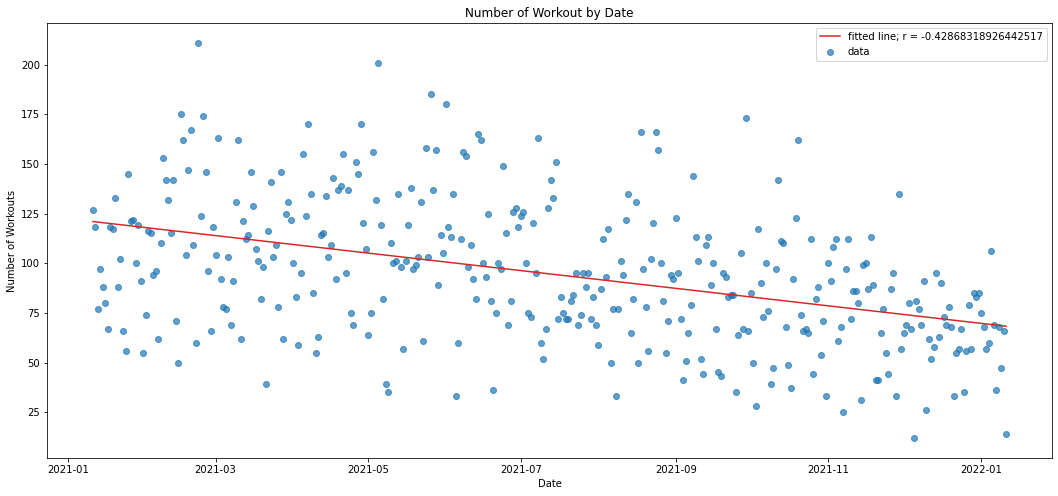

In [28]:
plt.figure(figsize=(18,8))
plt.scatter(dates, workout_counts, alpha = 0.7, label = 'data')
plt.plot(dates, intercept + slope*day_deltas, 'tab:red', label=f'fitted line; r = {r_value}')
plt.title("Number of Workout by Date")
plt.ylabel("Number of Workouts")
plt.xlabel("Date")
plt.legend()
plt.show()

From this visualization, it is pretty easy to see that there is a negative trend line in regards to the amount of workouts logged
and the time of the year. 

Specifically with an r_value of -.46, we can say there is a **moderately downhill (negative)** relationship between these two variables. 

This means that as the year progresses, users are less likely to be logging workouts

### How Many Workouts are Users Logging Throughout the Year?

This question is mostly centered around the idea that there will be disparities between the amount of workouts each user logs throughout the year. 

We will mostly be focused on whether this is a fairly linear relationship or whether there are clusters on each side of the spectrum.

For this analysis, we will be counting the number of unique workouts performed by each user within the dataset and plotting the results.

We will also take a look at the PDF (probability density function) and CDF (cumulative distribution function) for the amount of workouts in a year.

For any not familair with PDFs and CDFs:
- **PDF**: Shows the probability of the number of workouts being a certain value
- **CDF**: Shows the probability of the being less than or equal to a certain value

In [29]:
user_id = []
workout_count = []
for name, group in workout_data.groupby(["fake_user_id"]):
    user_id.append(name)
    workout_count.append(len(group["workoutId"].unique()))
workout_counts_users = pd.DataFrame.from_dict({"fake_user_id" : user_id,
 "workout_number" : workout_count})
workout_counts_users = workout_counts_users.sort_values(by="workout_number")

workout_nums = np.unique(workout_counts_users["workout_number"].values)
workout_values= workout_counts_users["workout_number"].values

pdf = []
for nums in workout_nums:
    pdf.append(len(workout_values[workout_values == nums])/(len(workout_values)))

cdf = []
for nums in workout_nums:
    cdf.append(len(workout_values[workout_values <= nums])/(len(workout_values)))

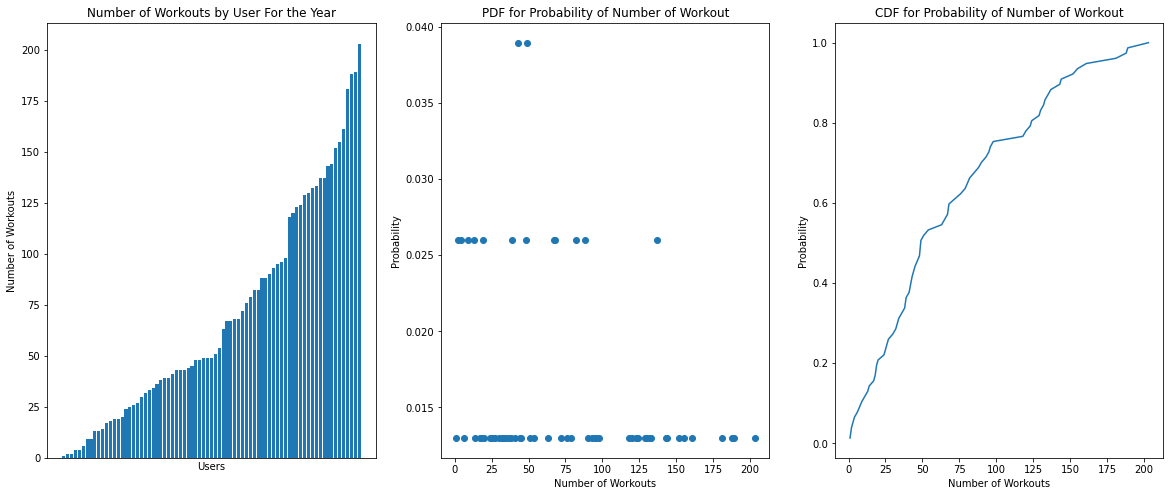

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(20,8))
axs[0].bar(workout_counts_users["fake_user_id"].values, workout_counts_users["workout_number"].values, label = "data")
axs[0].tick_params(bottom = False, labelbottom=False)
axs[0].set_xlabel("Users")
axs[0].set_ylabel("Number of Workouts")
axs[0].set_title("Number of Workouts by User For the Year")

axs[1].scatter(workout_nums, pdf)
axs[1].set_title("PDF for Probability of Number of Workout")
axs[1].set_xlabel("Number of Workouts")
axs[1].set_ylabel("Probability")

axs[2].plot(workout_nums, cdf)
axs[2].set_title("CDF for Probability of Number of Workout")
axs[2].set_xlabel("Number of Workouts")
axs[2].set_ylabel("Probability")

plt.show()

In [31]:
print("Workout Count Statistics:")
print(f"\t Mean: {np.mean(workout_count)}")
print(f"\t Standard Deviation: {np.std(workout_count)}")


Workout Count Statistics:
	 Mean: 69.23376623376623
	 Standard Deviation: 52.43595873951735


From these graphs, we can get a pretty good idea of the number of workouts users are logging. 

Our plots of the raw data show that its a fairly linear realtionship, maybe even slightly exponential relationship, for the amount of workouts done through the year. The average number of workouts logged is approximately 69. The standard deviation is also pretty high so this lets us know that we can expect a wide range of values when counting workouts.

The PDF and CDF add onto this information by telling us where most of the information is clustered. The PDF shows that our data is left skewed with a large portion of the data being below 100 workouts. The CDF confirms this information and tells us that approximately 75% of the amount of workouts logged throughout the year is less than 100. 

The CDF also shows an interesting feature with a plateau between approximately 100 and 125 workouts a year. 

### What is the Spread for the Number of Exercises within a Singular Workout?

This question will be looking at the number of exercises that are within a singular workout. Does this dataset have a large spectrum for the number of exercises or do we find that exercises are solely around a couple of values?

The results from this analysis can gather insight on how many exercises people are actually logging and we can correlate it with the workout programs that are being suggested.

To find the results for this analysis, we will be counting the number of unique exercises per workout. Once we have complied this count, we will find the range of the number of exercises and compile a count for each of these values. 

We will again be looking at the CDF and PDF of the counts of number of exercises to look for clusters and distrbutions.

In [42]:
counts = []
names = []
for name, group in workout_data.groupby("workoutId"):
    names.append(name)
    counts.append(len(group["exerciseName"].unique()))
counts = np.array(counts)
exercise_counts = []
for num in np.unique(counts):
    
    exercise_counts.append(len(counts[counts == num]))
    
cdf = []
probs = []
exercise_nums = np.unique(counts)
for nums in exercise_counts:
    probs.append(nums/(np.sum(exercise_counts)))
    
for i in range(0 ,len(probs) + 1):
    cdf.append(np.sum(probs[:i]))

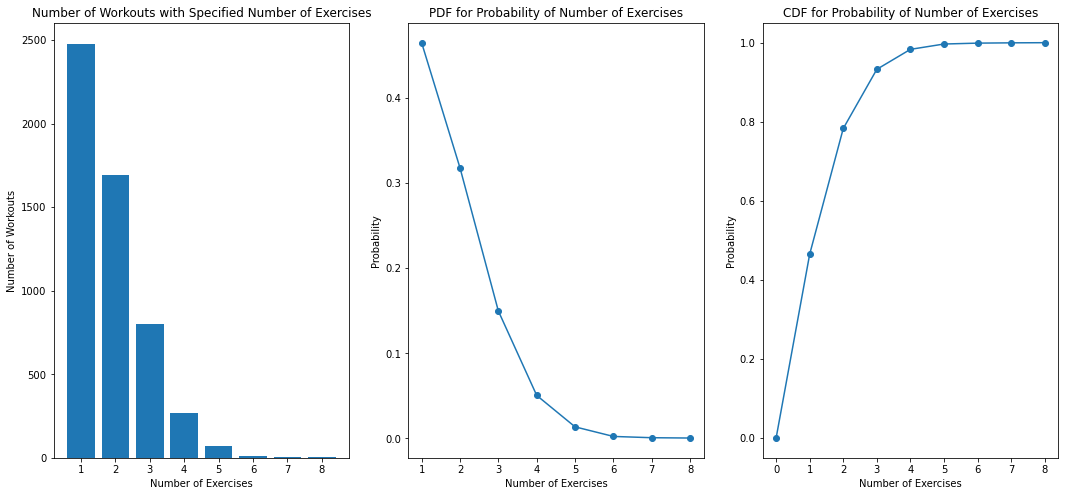

In [52]:
plt.figure(figsize=(18,8))
plt.subplot(1,3,1)
plt.bar(exercise_nums, exercise_counts)
plt.title("Number of Workouts with Specified Number of Exercises")
plt.xlabel("Number of Exercises")
plt.ylabel("Number of Workouts")
plt.subplot(1,3,3)
plt.plot(np.arange(0, exercise_nums.max() + 1), cdf, marker = "o")
plt.title("CDF for Probability of Number of Exercises")
plt.xlabel("Number of Exercises")
plt.ylabel("Probability")
plt.subplot(1,3,2)
plt.plot(np.arange(1, exercise_nums.max() + 1), probs, marker = "o")
plt.title("PDF for Probability of Number of Exercises")
plt.xlabel("Number of Exercises")
plt.ylabel("Probability")
plt.show()

This analysis has definitely lead to some interesting results. 

From the first graph labeled "Number of Workouts of Specified Number of Exercises", we can see that, within our dataset, the range for the number of exercises per workout is 1 to 8. We can see that a large majority of the recorded workouts only have 1 to 3 exercises, with 4 - 8 makes up a small percentage.

Since we are dealing with a rather small amount of data, the PDF and CDF present the same information as the bar graph. We can see from the CDF that the cumulative probabilty quickly increases until we hit 3 exercises which encompasses approximately 93% and then plateaus at 4 - 8. 

This analysis of this dataset suggests that when workouts are generated, there should be between 1 - 3 different exercises.

### Does the 1 Rep Max of an Exercise Increase Throughout the Year?

The last analysis we are going to perform is to look at whether an estimated 1 Rep Max increases through the year.

We will be looking at the 1 Rep Max at both the general exercise level and the by user level.

This analysis should lead directly into our prediction model and informs us whether predictions can be made on this aspect of the data.

In this specific analysis, we will be using an estimated 1 Rep Max (eRPM) for Back Squat (one of my favorite). 

This eRPM will be calculated with the following equation (adapted from [here](https://getbacktosport.com/latest-news/predictions-equations-for-1rm/)):

$$ \frac{100 * x}{100 - (y * 2.5)}$$

where $x$ is the weight for the exercise and $y$ is the number of reps.

In [53]:
weighted_exercises = workout_data[workout_data["weight"] > 0]
print(f'Weighted Exercise Use in Dataset ordered by Use: \r\n {weighted_exercises["exerciseName"].value_counts().index.values}')

Weighted Exercise Use in Dataset ordered by Use: 
 ['Back Squat' 'Dumbbell Kickbacks' 'Dumbbell Rear Delt Raise'
 'Russian Twist' 'Dumbbell Shoulder Raise' 'Bent Over Barbell Row'
 'Barbell Incline Bench Press' 'Seated Leg Curl' 'Barbell Shoulder Press'
 'Machine Fly' 'Dumbbell Shrug' 'Romanian Deadlift' 'Reverse Barbell Curl'
 'Machine Leg Press' 'Dumbbell Sumo Squat' 'Barbell Hip Thrust'
 'Dumbbell Pullover' 'Seated Machine Calf Press' 'Cable Crunch'
 'Dumbbell Squeeze Press' 'Dumbbell Clean' 'Calf Raise' 'Preacher Curl'
 'Shotgun Row' 'Kettlebell Upright Row' 'Side Laterals to Front Raise'
 'Reverse Grip Barbell Bent Over Row' 'Dumbbell Step Up'
 'Barbell Glute Bridge' 'Single Arm Lat Pulldown' 'Incline Dumbbell Row'
 'Step Up' 'Air Squats' 'Power Clean' 'Clean' 'Overhead Weighted Sit Up'
 'Kettlebell Front Squat' 'Leg Curl' 'Floor Press'
 'Dumbbell Decline Bench Press' 'Kettlebell Sumo High Pull'
 'Single Arm Overhead Press' 'Hang Clean' 'Pendlay Row' 'Clean and Jerk'
 'Smith Machi

#### Overall Exercise eRPM

The first section of this analysis will focus on the average eRPM for the Back Squat for every day of the year.

We are looking to see if there are any overall trends with this exercise over the year. 

In [54]:
exercise = "Back Squat"

In [55]:
def one_rep_max(weight, reps):
    multi_reps = reps * 2.5 
    percent_max = 100 - multi_reps
    rpm = weight/(percent_max/100)
    return rpm

specific_exercise = workout_data[workout_data["exerciseName"] == exercise]

date = []
rep_max = []
for name, group in specific_exercise.groupby(["Date"]):
    day_reps = []
    date.append(name)
    for idx, row in group.iterrows():
        rpm = one_rep_max(row["weight"], row["reps"])
        day_reps.append(rpm)
    rep_max.append(np.mean(day_reps))
one_rep_max_df = pd.DataFrame.from_dict({"Date":date, "average_rep_max": rep_max})

da = one_rep_max_df["Date"].dt.to_pydatetime()
delta = [(time - da[0]).days for time in da]

slope, intercept, r_value, p_value, std_err = ss.linregress(delta, rep_max)

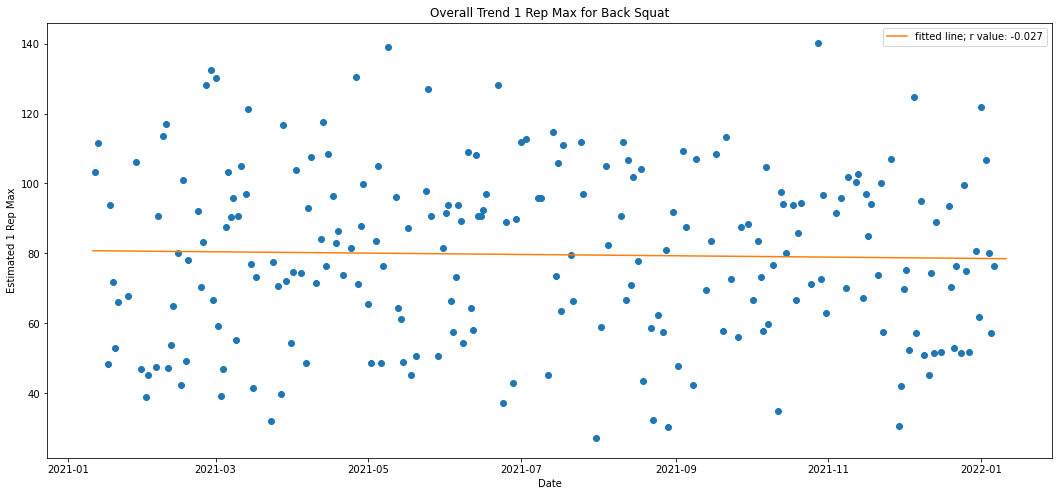

In [56]:
plt.figure(figsize=(18,8))
plt.scatter(date, rep_max)
plt.plot(dates, intercept + slope*day_deltas, 'tab:orange', label=f'fitted line; r value: {r_value:.3f}')
plt.title(f"Overall Trend 1 Rep Max for {exercise}")
plt.ylabel("Estimated 1 Rep Max")
plt.xlabel("Date")
plt.legend()
plt.show()

This graph shows that, for the Back Squat specifically, there is actually no relationship between the time of year the eRPM. 

With an r value of -0.027 we see that there is a neglible downward trend for the eRPM.

This could be do to a large number of things. Since we are plotting the average eRPM for each every user, we could be simply removing any trend in the data because we have now combined long term users with users who are just starting. We are also combining users who have an upward trends in eRPM with users with a negative trends, therefore negating any relationship that was forming.

There could also be an interaction between this and the number of actual workouts performed during the year. Since the previous analysis showed that we have a less workouts recorded as the year progress, it most likely influences the trend since there just simply isn't as much data as there was during the beginning of the year.

#### eRPM Trend for Top 4 Exercise Users

Since one of the reasons that we didn't see a trend in the previous graph was due to the combination of different user data, the other part of this analysis will be looking at trends of the top 4 users with the most logged Back Squat. 

The top 4 were chosen largely because we wanted to make sure there would be enough data to evaulate a meaningful trend within the data.


In [58]:
top_4_users = specific_exercise["fake_user_id"].value_counts().index.values[:4]

exer_user = {}
fitted_lines = []
for user in top_4_users:
    exer_user[user] = {"Date":[], "RPM":[]}
    user_data = specific_exercise[specific_exercise["fake_user_id"] == user]
    for name, group in user_data.groupby(["Date"]):
        day_reps = []
        exer_user[user]["Date"].append(name)
        for idx, row in group.iterrows():
            rpm = one_rep_max(row["weight"], row["reps"])
            day_reps.append(rpm)
        exer_user[user]["RPM"].append(np.mean(day_reps))
    delta = [(time - exer_user[user]["Date"][0]).days for time in exer_user[user]["Date"]]

    slope, intercept, r_value, p_value, std_err = ss.linregress(delta, exer_user[user]["RPM"])
    fitted_lines.append([np.array(delta), slope, intercept, r_value, p_value, std_err])

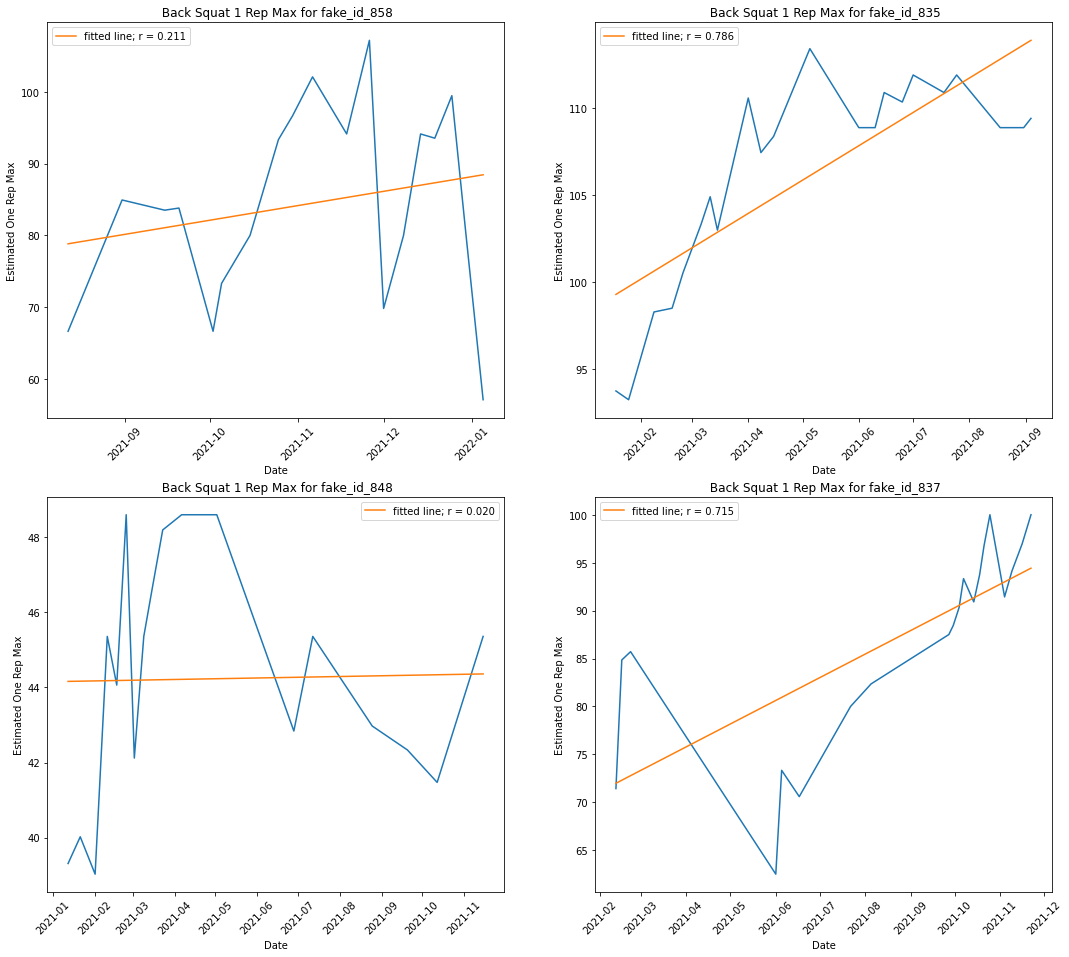

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(18,16))
for i in range(len(top_4_users)):
    data = exer_user[top_4_users[i]]
    line_data = fitted_lines[i]
    plt.subplot(2,2,(i+1))
    plt.plot(data["Date"], data["RPM"],)
    plt.plot(data["Date"], line_data[2] + line_data[1]*line_data[0], 'tab:orange', label=f'fitted line; r = {line_data[3]:.3f}')
    plt.title(f" {exercise} 1 Rep Max for {top_4_users[i]}")
    plt.xlabel("Date")
    plt.xticks(rotation=45)
    plt.ylabel("Estimated One Rep Max")
    plt.legend()
plt.show()


These four graphs of the users make it pretty clear that we were correct about there being interacting trends within the data for a single exercise. 

Both fake_user_835 and fake_user_837 have very strong postive correlation between time of year and eRPM while fake_user_858 and fake_user_848 have a weak postive realtionship and no relationship respectively.

These graphs are a goood indicator for model and suggest that are some exercises that we can use to build a model to represent an athletes progress.

## Pediction of 1 Rep Max at Competition Date

The time has come! Now with the data cleaned and trends analyzed, we can now put together our prediction model.

As stated earlier, the goal of this prediction model is to be able to predict what the next 1 Rep Max for a user on a specfic exercise.

The hope is that this model will help athletes get an overall view of their progress and guage where they are in relation to their competition goals.

### Model Building

Since we have are looking to predict a continous variable and not a specific class, the machine learning method of choice would be a regression model.

A **simple linear model** is probably the best regression method for this dataset since we have a limited number of variables that relate to the eRPM. 

We could do multiple linear regression, but we figure there is only 1 of the 6 main variables we could use to predict eRPM: Date. 
- Both fake_user_id and exerciseName are used to filter the dataset which makes them ineligible for prediction use because they have become a static variable within the dataset. 
- workoutId is more of a descriptive key used to group exercises
- Since eRPM is a derived feature from both reps and weight, it wouldn't make sense to include them in the model because we already have a model to connect how they are related.

This just leaves Date left to try and predict our eRPM. 

Similiar to what was explained above, we can't use categrical variables for regression so the Date variable will be transform to a vector of time deltas from the first date in the data set 01/01/2021.

We'll create a simple linear model to capture the relationship between the **time deltas from 01/01/2021** and the **eRPM for a specific user and exercise**. 

The data will will be split into a 80/20 train/test split.

In [73]:
user = "fake_id_835"
exercise = "Back Squat"

In [74]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
data = workout_data[ (workout_data["fake_user_id"] == user)
                    & (workout_data["exerciseName"] == exercise)].sort_values(by="Date")
data["day_delta"] = [int(time - data["Date"].values[0]) for time in data["Date"].values]
data["eRPM"] = [one_rep_max(row["weight"], row["reps"]) for idx, row in data.iterrows()]

x_train, x_test, y_train, y_test = train_test_split(data[["day_delta"]], data["eRPM"], train_size=.80)

linreg = linear_model.LinearRegression()

model = linreg.fit(x_train, y_train)

predict = linreg.predict(x_test)

### Model Evaluation
Now that we have trained the model and predicted on our test data, we need to evaulate the model and predicted results to see how well they fit to the data.

The evaluation measure we will use are:
- Statistics of Residuals
- Root Mean Squared Error
- R2 Score

#### Residual Probabilites

Residuals are the differences between a predicted data points and its counterpart truth point. These values can tell you where you are spot on predicting, under predicting, or over predicting. 

For this evaluation measure, we will look at the residuals and the probailities of either under predicting or over predicting.

#### Root Mean Squared Error (RMSE)

Put simply, the RMSE is the average distance between truth points and predicted points. It is good singular value that tells us how much error is within our model and how close our model is to predicting correct values.

#### R Squared Score

The R Squared Score quantifies the total variance variance of our dependent variable (eRPM) that is explained by our independent variable (Date). It can be thought of as the percentage of the variance within the data that is explained by the model.

The range for this metric is between 0 and 1. The closer the value is to 1 the closer our model represents the data. 



In [83]:
rmse = np.sqrt(mean_squared_error(y_test.values, predict))
r2 = r2_score(y_test.values, predict)

#print(f"Coefficients: \n {model.coef_} \r\n")
print(f"RMSE Value : \n {rmse} \r\n")
print(f"R Squared Value: \n {r2}\r\n")

residuals = y_test.values - predict

under_predicted = residuals[residuals < 0]
over_predicted = residuals[residuals > 0]

print(f"{len(under_predicted)/len(residuals) * 100:.2f}% of the time, the model predicted under the eRPM \r\n")
print(f"{len(over_predicted)/len(residuals) * 100:.2f}% of the time, the model predicted over the eRPM \r\n")

under_predicted.sort()
under_probs = []
for val in np.unique(under_predicted):
    under_probs.append((len((under_predicted[under_predicted <= val]))/len(under_predicted)))
                       
over_predicted.sort()
over_probs = []
for val in np.unique(over_predicted):
    over_probs.append((len((over_predicted[over_predicted <= val]))/len(over_predicted)))


RMSE Value : 
 3.467448031315018 

R Squared Value: 
 0.6476862881685639

42.11% of the time, the model predicted under the eRPM 

57.89% of the time, the model predicted over the eRPM 



We would say overall that this model does a fairly decent job predicting the eRPM given that we have only trained it on a single indedepent variable.

**RMSE**: Our RMSE value for this model is ~3.5. This means that the average distance between our predicted eRPM and our actual eRPM is about 3.5 lbs. While there does seem to be some variance in the model predictions,  it is a good starting model and would give the athlete a good sense of where they could be in a certain amount of time.

**R Squared Value**: With an r squared value of .64, it means our model using only the Date explains about 64% of the variance that is seen within the eRPM. While not perfect, we do think it is a great starting point for the prediction model

**Residuals and Under/Over Predicting**: It looks like the model is fairly uniform in either under predicting or over predicting the eRPM. It does skew slightly towards over predicting. We'll take a closer look at the residuals in the next set of graphs.

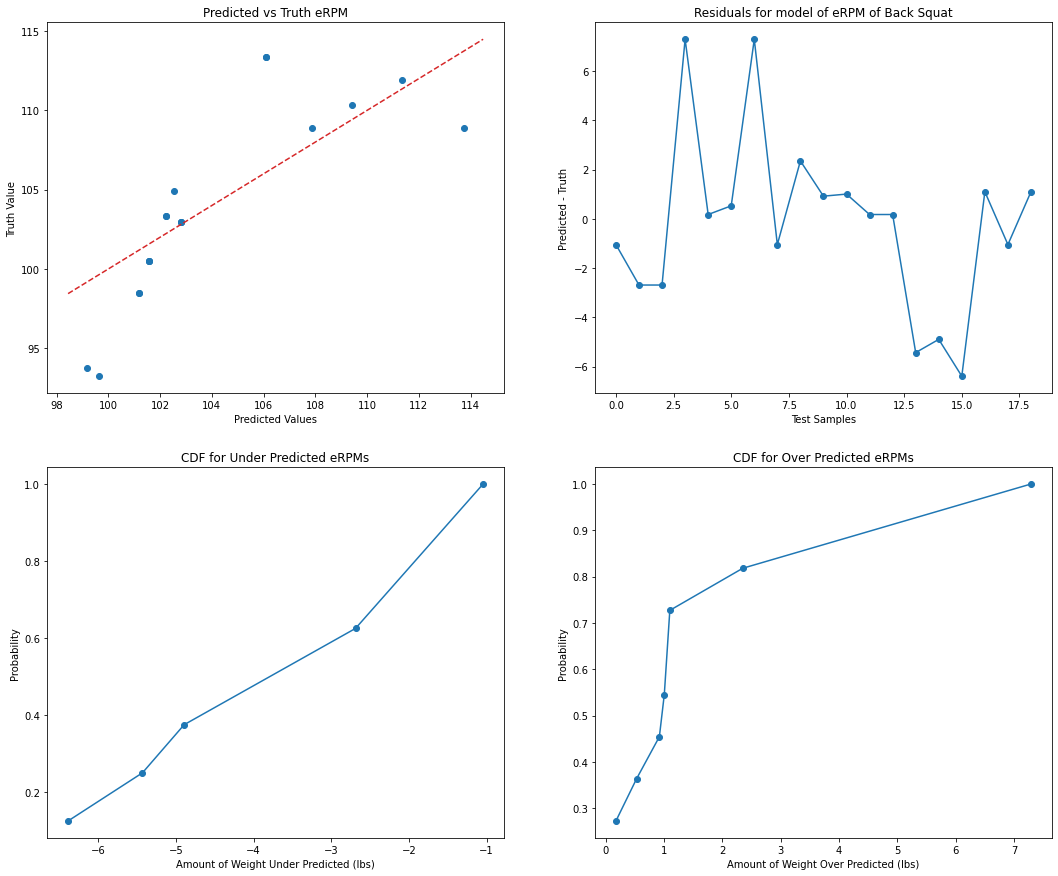

In [81]:
plt.figure(figsize=(18,15))
plt.subplot(2,2,1)
plt.scatter(predict, y_test.values)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, ls="--", c="tab:red")
plt.title("Predicted vs Truth eRPM")
plt.ylabel("Truth Value")
plt.xlabel("Predicted Values")

plt.subplot(2,2,2)
plt.plot(residuals, marker = "o")
plt.title(f"Residuals for model of eRPM of {exercise}")
plt.ylabel("Predicted - Truth")
plt.xlabel("Test Samples")

plt.subplot(2,2,3)
plt.plot(np.unique(under_predicted), under_probs, marker = "o")
plt.title("CDF for Under Predicted eRPMs")
plt.ylabel("Probability")
plt.xlabel("Amount of Weight Under Predicted (lbs)")

plt.subplot(2,2,4)
plt.plot(np.unique(over_predicted), over_probs, marker="o")
plt.title("CDF for Over Predicted eRPMs")
plt.ylabel("Probability")
plt.xlabel("Amount of Weight Over Predicted (lbs)")

plt.show()


**Predicted vs. Truth eRPM**: The dotted red line shows where the model would be if it were predicted correctly 100% of the time. The further the values are away from the line, the larger the error for the prediction. The model does rarely correctly guess the eRPM but it is mostly witin -+ 5 lbs of the truth values. 

**Residuals**: This graph does a better job of showing the exact difference between the predicted and truth variables. We can that we do have some large over predictions and under predictions. Again this graph does verify that the model is within +- 3 lbs of the actual eRPM

**CDF for Under Prediction**: It's interesting to see that the model is fairly uniform in each of the under predicted eRPMs. There doesnt seem to be a specfic number that the model is underpredicting to.

**CDF for Over Prediction**: Now this graph tells a drastically different story than the under predicting CDF. The model is extremely more likely (about 85% of the time) to be +3 lbs or less compared to the actual value

### Lets Predict!

Now that we have verified the model, lets predict what estimated 1 Rep Max this user will have on: 

**03/03/2022**

In [77]:
from datetime import datetime
date = "2022-03-03"
last_weight = 105
last_rep = 10
comp_date = np.datetime64(date)
day_delta = comp_date - data["Date"].values[0]
days = day_delta.astype('timedelta64[D]')
test_delta = pd.DataFrame.from_dict({"day_delta": [days / np.timedelta64(1, 'D')]})

In [76]:
print(f"According to the model, {user} will lift approximatel {model.predict(test_delta)[0]:.2f} pounds for {exercise} on {date}")

According to the model, fake_id_835 will lift approximatel 99.17 pounds for Back Squat on 2022-02-03


## Further Steps
1. Research new way to build eRPM feature
2. Use ARMA (auto regressive moving average) model to capture more nuanced trends
3. Try a non linear regression to better fit the trends of muscle gain and performance